### Time to get your hands dirty. Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new it's computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from astroML.utils import split_samples, completeness_contamination
import corner
import warnings
warnings.simplefilter('ignore')

In [ ]:
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        #print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs

In [ ]:
def plot_roc(y_t):
    names, probs = compute_models((GaussianNB, {}),
                              (LinearDiscriminantAnalysis, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (LogisticRegression,
                               dict(class_weight='balanced')),
                              (KNeighborsClassifier,
                               dict(n_neighbors=10)),
                              (DecisionTreeClassifier,
                               dict(random_state=0, max_depth=12,
                                    criterion='entropy')),
                              (GMMBayes, dict(n_components=3, tol=1E-5,
                                              covariance_type='full')))
    labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')
    
    fig = plt.figure(figsize=(15, 5))
    fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# ax1 will show roc curves
    ax1 = plt.subplot(131)

# ax2 will show completeness/efficiency
    ax2 = plt.subplot(132)

# ax3 will show precision/recall
# ax3 = plt.subplot(133)

    thresholds = np.linspace(0, 1, 1001)[:-1]

# iterate through and show results
    for name, y_prob in zip(names, probs):
        fpr, tpr, thresh = roc_curve(y_t, y_prob)
        precision, recall, thresh2 = precision_recall_curve(y_t, y_prob)

        # add (0, 0) as first point
        fpr = np.concatenate([[0], fpr])
        tpr = np.concatenate([[0], tpr])
        # Here we add (1,0) 
        precision = np.concatenate([[0], precision])
        recall = np.concatenate([[1], recall])
        thresh2 = np.concatenate([[0], thresh2])

        ax1.plot(fpr, tpr, label=labels[name])
    
        #See note above about astroML vs. sklearn
        #Note that the range of threshhold values here is 0% to 100% (0.0 to 1.0)
        comp = np.zeros_like(thresholds)
        cont = np.zeros_like(thresholds)
        for i, t in enumerate(thresholds):
            y_pred = (y_prob >= t)
            comp[i], cont[i] = completeness_contamination(y_pred, y_t)
        ax2.plot(1 - cont, comp, label=labels[name])
        
    #ax3.plot(precision, recall, label=labels[name])

    ax1.set_xlim(0, 0.04)
    ax1.set_ylim(0.7, 1.02)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax1.set_xlabel('false positive rate')
    ax1.set_ylabel('true positive rate')
    ax1.legend(loc=4)
    
    ax2.set_xlabel('efficiency')
    ax2.set_ylabel('completeness')
    ax2.set_xlim(0, 1.0)
    ax2.set_ylim(0.7, 1.02)
    
    #ax3.set_xlabel('precision')
    #ax3.set_ylabel('recall')
    #ax3.set_xlim(0, 1.0)
    #ax3.set_ylim(0.2, 1.02)
    
    plt.show()

In [ ]:
df = pd.read_csv("../solutions/galaxyquasar.csv")
df

In [ ]:
df['u-g'] = df['u']- df['g'] 
df['g-r'] = df['g']- df['r'] 
df['r-i'] = df['r']- df['i']
df['i-z'] = df['i']- df['z']

In [ ]:
le = LabelEncoder()
# Assign unique integers: 1 QSO, 0 galaxy
df['class'] = le.fit_transform(df['class'] )
labels_class = le.inverse_transform(df['class'] )
class_names = le.classes_
print('Class names: ', class_names)
print('Labels: ', labels_class)

In [ ]:
(X_train, X_test), (y_train, y_test) = split_samples( df.loc[:, 'u-g':'g-r'], df['class'], [0.75, 0.25], random_state=0)

plot_roc(y_test)

In [ ]:
(X_train, X_test), (y_train, y_test) = split_samples( df.loc[:, 'u-g':'r-i'], df['class'], [0.75, 0.25], random_state=0)

plot_roc(y_test)

In [ ]:
(X_train, X_test), (y_train, y_test) = split_samples( df.loc[:, 'u-g':'i-z'], df['class'], [0.75, 0.25], random_state=0)

plot_roc(y_test)

In [ ]:
corner.corner((df.loc[:, 'u-g':'i-z']), labels=['u-g', 'g-r', 'r-i', 'i-z']);

In [ ]:
plt.hist(df.loc[:, 'u-g'], bins = 50, histtype = 'step', label = 'all data')
plt.hist(df.loc[:, 'u-g'][labels_class=='QSO'], bins = 50, label = 'QSO')
plt.hist(df.loc[:, 'u-g'][labels_class=='GALAXY'], bins = 50, label = 'GALAXY')
plt.xlim(-1,3)
plt.legend();

In [ ]:
names = [
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    GMMBayes(),
    RandomForestClassifier()
]

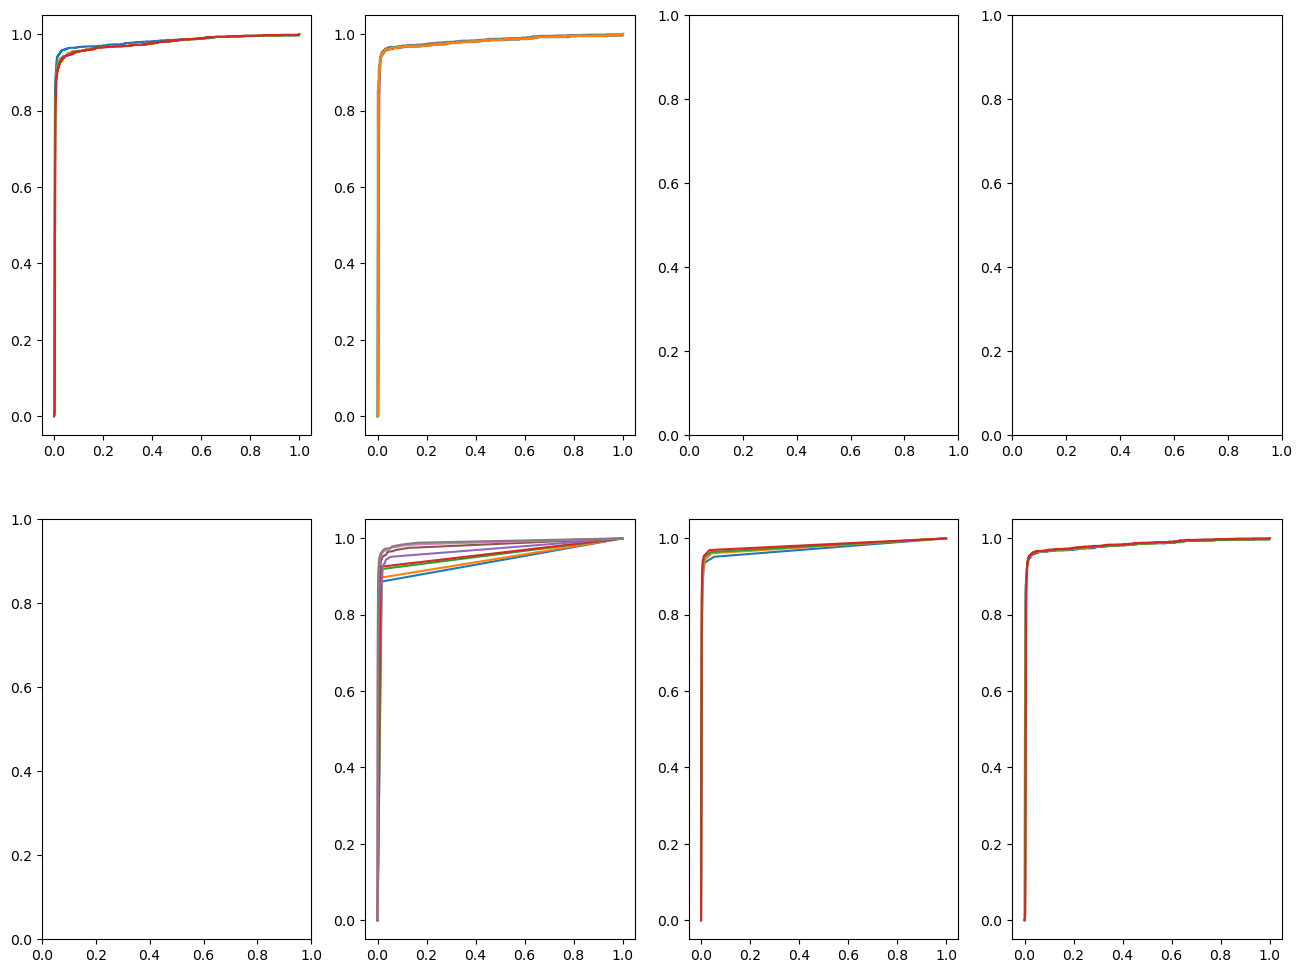

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [175]:
clf = GaussianNB()
(X_train, X_test), (y_train, y_test) = split_samples( df.loc[:, 'u-g':'i-z'], df['class'], [0.75, 0.25], random_state=0)


fig, axes = plt.subplots(2, 4, figsize=(16, 12))
for idx, clf in enumerate(names):
    fig = plt.figure(figsize =(12,6))
    for i in range(4):
        clf.fit(X_train[:, 0:i+1], y_train)
        y_prob = clf.predict_proba(X_test[:,0:i+1]) [:,1]     
        fpr, tpr, thresh = roc_curve(y_test, y_prob)
        if idx%2 == 0:
            axes[int(np.floor(idx/4))][int(idx/2)].plot(fpr, tpr, label='N features = ' +str(i+1))
        else:
            axes[int(np.floor(idx/4))][int(idx%2)].plot(fpr, tpr, label='N features = ' +str(i+1))
    #axes[idx%2][idx].set_ylim(0.9, 1.02)
    #plt.legend()

plt.show()
